In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

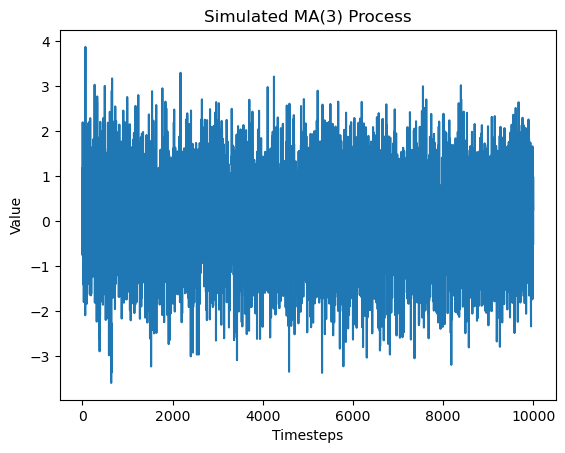

In [50]:
#Simulate a stationary MA(3) process yt = 0.9θt−1 + 0.3θt−2 + 0.2θt−3. To do so, use the 
#ArmaProcess function from the statsmodels library.
ma_coefs = [0.9, 0.3, 0.2]
arma_process = ArmaProcess(ma=ma_coefs)

# Generate 10,000 samples
num_samples = 10000
samples = arma_process.generate_sample(nsample=num_samples)

# Plot your simulated moving average
plt.plot(samples)
plt.xlabel('Timesteps')
plt.ylabel('Value')
plt.title('Simulated MA(3) Process')
plt.show()

In [51]:
#Run the ADF test, and check if the process is stationary.
ADF_result = adfuller(samples)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -36.84624929717174
p-value: 0.0


As we can see the p-value we got is less than 0.05 which means that the process is stationary

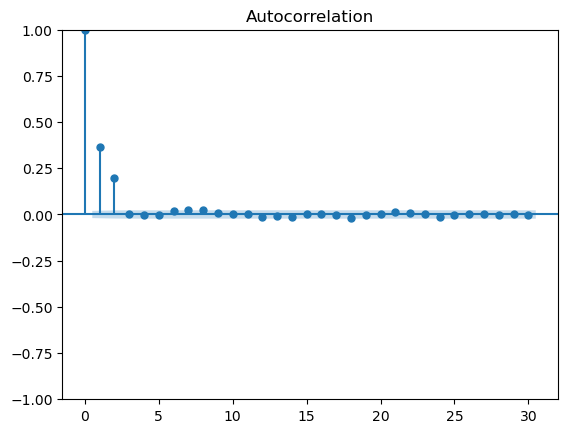

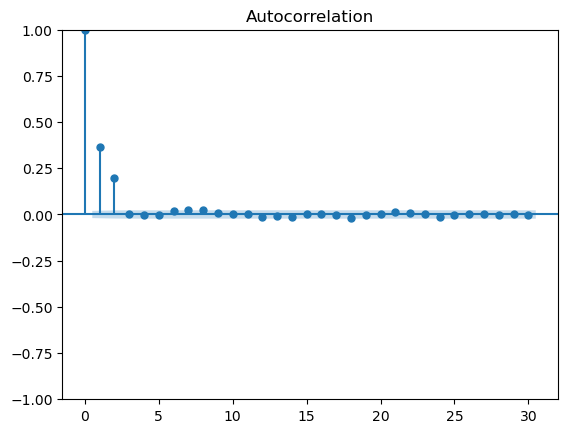

In [52]:
#Plot the ACF, and see if there are significant coefficients after lag 3
plot_acf(samples, lags=30)

As we can see from the plot, there are no significant coefficients after lag three which proves that we have a stationary moving average process of order 3 and that we can use MA(3) model to work with our stationary process.

In [53]:
#Separate your simulated series into train and test sets. Take the first 9,800 timesteps for 
#the train set, and assign the rest to the test set.
test = samples[-200:]
train = samples[:-200]

In [54]:
#Make forecasts over the test set. Use two baseline models of your choice, and an MA(3)
#model. Make sure you repeatedly forecast 3 timesteps at a time.

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i])
            pred_mean.extend([mean] * window)
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[i - 1]
            pred_last_value.extend([last_value] * window)
        return pred_last_value
    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,3))
            res = model.fit()
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA

In [55]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 3

pred_mean = rolling_forecast(samples, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(samples, TRAIN_LEN, HORIZON, WINDOW,'last')
pred_MA = rolling_forecast(samples, TRAIN_LEN, HORIZON, WINDOW, 'MA')

In [57]:
pred_mean = pred_mean[:len(test)]
pred_last_value = pred_last_value[:len(test)]
pred_MA = pred_MA[:len(test)]

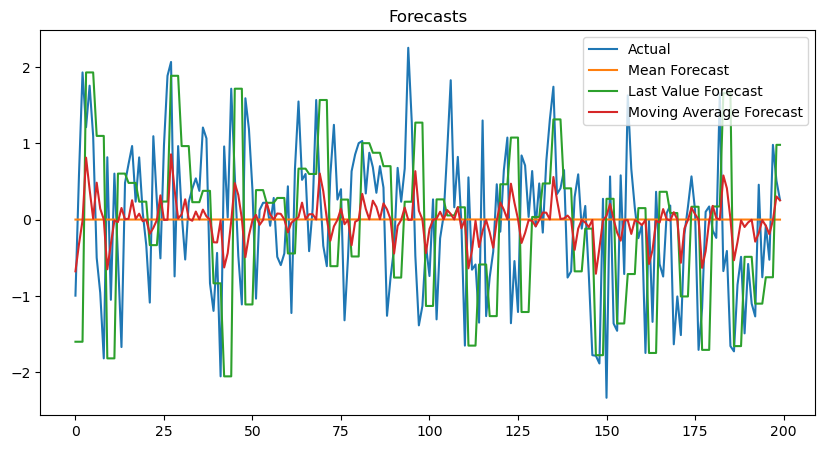

In [59]:
#Plot your forecasts on the same graph.
plt.figure(figsize=(10, 5))
plt.plot(pred_df.index, test, label='Actual')
plt.plot(pred_df.index, pred_mean, label='Mean Forecast')
plt.plot(pred_df.index, pred_last_value, label='Last Value Forecast')
plt.plot(pred_df.index, pred_MA, label='Moving Average Forecast')
plt.title('Forecasts')
plt.legend()
plt.show()

In [60]:
#Measure the MSE, identify your champion model
mse_mean = mean_squared_error(test, pred_mean)
mse_last = mean_squared_error(test, pred_last_value)
mse_MA = mean_squared_error(test, pred_MA) 

print("Historical mean error: ", mse_mean) 
print("Last known value error: ", mse_last) 
print("MA(3) error: ", mse_MA) 

Historical mean error:  0.8999065138897562
Last known value error:  1.773456878422565
MA(3) error:  0.8779657776602394


Moving average is the champion model

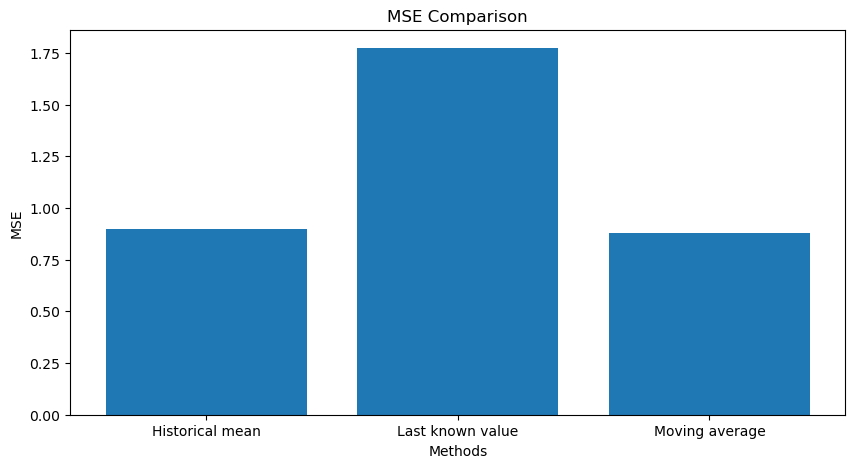

In [61]:
#and draw the MSEs in a bar plot
mse_values = [mse_mean, mse_last, mse_MA]
methods = ['Historical mean', 'Last known value', 'Moving average']

plt.figure(figsize=(10, 5))
plt.bar(methods, mse_values)
plt.xlabel('Methods')
plt.ylabel('MSE')
plt.title('MSE Comparison')
plt.show()